In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import integrate as inte
from astropy import units as u
from astropy import constants as const
import xarray as xr
import seaborn as sns

In [2]:
#constants and units
H0 = 67.9 * u.km/u.s/u.Mpc
c = const.c
G = const.G.to(u.km**2 * u.Mpc /u.Msun/u.s**2)
chirpM = 26*u.Msun
rho_crit = (3/8/np.pi) * H0**2 /G # has dimensions of density (mass/volume)

fref = 25. /u.s
OmegaGW_limit = 4.8e-8
Rate = 53.2 /(u.Gpc**3 * u.year)
t_obs = 1.5 *u.year

#mass distribution parameters
m_min = 6.7 #minimum allowed component mass
m_max = 41.9 #maximum allowed component mass
gamma = -1.4 #power law spectral index for individual component masses
beta_q = 4 #spectral index for selection function: f(q) \prop q^beta_q

## Horizon Distance of a Euclidian Universe 

$$ r_{\text{hor}} = \frac{9\Omega_{\text{ref}} H_0^2 c^3}{8 \mathcal{R}} (f_{\text{ref}})^{-2/3} ( G \pi \mathcal{M})^{-5/3} $$ 

Where $\mathcal{R}$ is the rate density of events. Here we have assumed it to be the local merger rate $\mathcal{R}_0$. 

In [4]:
def r_hor(H0,c,G,Mchirp,Omega,fref,R):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    GpiM53 = np.power(G*np.pi*Mchirp,-5./3)
    Hoc = H0**2 *(c**3)
    
    rhor = (9/(8 * R)) * Hoc * GpiM53 * Omegaf
    return rhor

In [5]:
r = r_hor(H0,c,G,chirpM,OmegaGW_limit,fref,Rate)
r.to(u.Gpc)

<Quantity 87.6129624038377 Gpc>

In [6]:
hubble_dist = c/H0
(r/hubble_dist).to(u.m/u.m)

<Quantity 19.84346166313644>

In [8]:
#chirp mass for two 30 solar mass BHs
m = 30 * u.Msun
M53 = m*m*(m+m)**(-1/3)
M53**(3/5)

<Quantity 26.1165169 solMass>

In [26]:
# if you want to integrate over observing time instead of the age of the U (this no longer makes sense)
def r_hor_tobs(H0,c,G,Mchirp,Omega,fref,R,tobs):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    GpiM53 = np.power(G*np.pi*Mchirp,-5./3)
    Hoc = H0 *(c**3)
    N = R * tobs
    
    rhor = (9./(8 *N)) * Hoc * GpiM53 * Omegaf
    return rhor

In [21]:
r = r_hor_tobs(H0,c,G,chirpM,OmegaGW_limit,fref,Rate,t_obs)
r.to(u.Gpc)

<Quantity 841112156663.8446 Gpc>

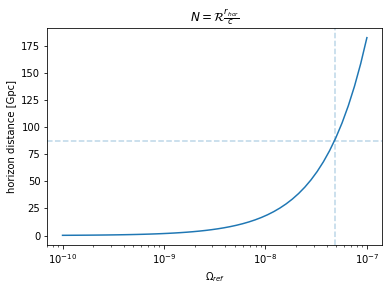

In [9]:
#plot them
possible_omegas = np.logspace(-10,-7)
# --- t= age of U ---#
plt.plot(possible_omegas,r_hor(H0,c,G,chirpM,possible_omegas,fref,Rate).to(u.Gpc))
plt.axvline(OmegaGW_limit,linestyle='--',alpha=0.3)
plt.axhline(87.6,linestyle='--',alpha=0.3)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\Omega_{ref}$')
plt.ylabel('horizon distance [Gpc]')
plt.title(r'$N = \mathcal{R}\frac{r_{hor}}{c}$')
plt.show()
# #--- t = t_obs ---#
# plt.plot(possible_omegas,r_hor_tobs(H0,c,G,chirpM,possible_omegas,fref,Rate,t_obs).to(u.Gpc))
# plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel(r'$\Omega_{ref}$')
# plt.ylabel('horizon distance [Gpc]')
# plt.title(r'$N = \mathcal{R}t_{obs}$')
# plt.show()

### Adding in a mass distribution

$$\rho_c c^2 \Omega_{GW}(f) =  r_{hor} \frac{H_0}{c} \frac{(f G \pi)^{2/3}}{3 (2)^{1/3}} \int d t \frac{\mathcal{R}_0 (2\gamma +1)}{m_{max}^{2\gamma +1} - m_{min}^{2\gamma +1}} [\frac{m_{max}^{2\gamma +8/3} - m_{min}^{2\gamma +8/3}}{(2\gamma +8/3)}] $$

In [14]:
#this assumes equal masses and a power law for each component mass
def r_hor_marg_Mchirp(H0,c,G,Omega,fref,R0):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    Gpi53 = np.power(np.pi,-5./3)
    Hoc = H0**2 * (c**3)
    
    prefac = R0/(2**(1./3))
    power = (2 * gamma + 1)
    norm = power /(np.power(m_max,power) - np.power(m_min,power))    
    RofM = norm * prefac \
    * (np.power(m_max,power)*np.power(m_max*G,5./3)-np.power(m_min,power)*np.power(m_min*G,5./3)) \
    / (power+5./3)
    #(you have to do some finegling to get the 5/3 thing to cancel units with the mass in G properly but this does the trick^)
    
    rhor = (9./(8 *RofM)) * Hoc * Gpi53 * Omegaf
    return rhor

In [15]:
r_hor_marg_Mchirp(H0,c,G,OmegaGW_limit,fref,Rate).to(u.Gpc)

<Quantity 348.01806764493966 Gpc>

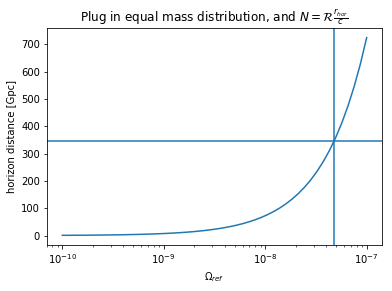

In [16]:
plt.plot(possible_omegas,r_hor_marg_Mchirp(H0,c,G,possible_omegas,fref,Rate).to(u.Gpc))
plt.axvline(OmegaGW_limit)
plt.axhline(348.0)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\Omega_{ref}$')
plt.ylabel('horizon distance [Gpc]')
plt.title(r'Plug in equal mass distribution, and $N = \mathcal{R}\frac{r_{hor}}{c}$')
plt.show()

## Putting Limits on FLRW parameters

$ \rho_c c^2 \Omega_{GW} (f) = \frac{(f \pi G)^{2/3}}{3} \mathcal{R_0} \int_0^{z_f} \frac{\mathrm{d}z}{(1+z)^{1/3} H(z)} \text{(massfac)(z-evo)} $

where $ \text{massfac} = \int_0^\infty \text{d}\mathcal{M} \frac{\text{d}\mathcal{R}(\mathcal{M},z)}{\text{d}\mathcal{M}} \mathcal{M}^{5/3}$ accounts for the mass distribution of binaries and $ \text{z-evo} = \mathcal{C}(\alpha,\beta,z_p) \frac{(1+z)^{\alpha}}{1 + (\frac{1+z}{1+z_p})^{\alpha+\beta}} $ is the redshift evolution of the merger rate.

In [3]:
#mass distributions
def equal_masses(gamma,m_min,m_max):
    '''lets again assume the equal masses model that does not evolve in redshift 
    (eventually we will want to evolve it in redshift so that zf has an astrophysical rather that cosmological meaning)
    '''
    prefac = 1./(2**(1./3))
    power = (2 * gamma + 1)
    norm = power /(np.power(m_max,power) - np.power(m_min,power)) 
    massfac = norm * prefac \
    * (np.power(m_max,power)*np.power(m_max,5./3)-np.power(m_min,power)*np.power(m_min,5./3)) \
    / (power+5./3)
    return massfac

def plaw_selection(gamma,m_min,m_max):
    ''' this is a power law mass distribution with a selection function 
    for the mass ratio that is proportional to (m2/m1)** beta_q'''
    def int_over_m2(m1_arr,power_of_m2):
        return (np.power(m1_arr,power_of_m2+1) - np.power(m_min,power_of_m2+1))/ (power_of_m2 +1)
    def int_over_m1(m1_arr,m2_int_arr,power_of_m1):
        integrand = m2_int_arr * np.power(m1_arr,power_of_m1) 
        return inte.trapz(integrand)
    possible_masses = np.linspace(m_min,m_max)
    p_m1_m2_integral_A= int_over_m2(possible_masses,gamma+beta_q)
    p_m1_m2_integral_B = int_over_m1(possible_masses,p_m1_m2_integral_A,gamma-beta_q)
    p_norm = 1./p_m1_m2_integral_B
        
    def p_m1_m2(m2,m1):
        f_q = np.power(m2/m1,beta_q)
        p_m1_m2 = f_q * np.power(m1 * m2, gamma)
        return p_m1_m2
    def mass_integrand(m2,m1):
        return p_m1_m2(m2,m1) * (m1 * m2) / np.power(m1 + m2, 1./3)
    def double_integral(integrand):
        int_over_m2 = np.zeros(len(possible_masses)) 
        for i in range(len(int_over_m2)):
            # does it make sense for the upper limit and m1 argument in p to be the same?
            int_over_m2[i] = inte.quad(integrand, m_min, possible_masses[i],args=possible_masses[i])[0]
        int_over_m1 = inte.trapz(int_over_m2)
        return int_over_m1
    
    #p_norm = 1./ double_integral(p_m1_m2) #this works too! its just slower.
    integral = double_integral(mass_integrand) 
    
    return p_norm * integral

#redshift evolution
def int_over_z(z,Omega_m,Omega_Lam,Omega_r, zp=0,alpha=0,beta=0):
    ''' putting in values for zp, alpha, and beta gives the redshift evolution in Callister et al 2020'''
    Omega_k = 1 - (Omega_m + Omega_Lam + Omega_r)
    H_z = np.sqrt(Omega_Lam + Omega_r * (1 + z)**4. + Omega_m * (1 + z)**3. + Omega_k * (1 + z)**2. )
    
    z_evo = np.power(1+z,alpha)/(1+ np.power((1+z)/(1+zp),beta))
    C =  1 + np.power(1+zp,-1*(alpha+beta))
    
    integrand = z_evo * C / ((1+z)*H_z)
    return integrand

#final fractional energy density
def OmegaGW(zf,Omega_m,fref,massdist=equal_masses,z_evo_params=[0,0,0]):
    fpiG = np.power(fref*np.pi*G,2./3)/3.
    rhoc2 = ( c**2 ) * ( H0**2 ) * 3 /( 8 * np.pi * G )
    massfac = massdist(gamma,m_min,m_max) * np.power(u.Msun,5./3)
    integral = inte.quad(int_over_z,0,zf,
                         args=(Omega_m, 1-Omega_m,0,z_evo_params[0],
                               z_evo_params[1],z_evo_params[2])
                        )[0]
    integral *= 1./H0
    
    return (integral * Rate * massfac * fpiG / rhoc2).to(u.m/u.m)

In [4]:
#define arrays for evaluating
zf_array = np.linspace(0.1, 10,num=50)
Omega_m_array = np.linspace(0,1.4,num=50)
Omega_gw_z_free = np.zeros(len(zf_array))
Omega_gw_Omegam_free = np.zeros(len(Omega_m_array))

redshift_evolution_parameters = [5.,2.,7.] #zpeak, alpha, beta
#test
OmegaGW(1000,0.3,fref,massdist=plaw_selection,z_evo_params=redshift_evolution_parameters)

<Quantity 4.53277984e-09>

I've noticed that changing beta_q by an order of magnitude only changes the second decimal of the above result

In [5]:
#have to do it with a loop because of how inte.quad works
for i in range(len(zf_array)):
    Omega_gw_z_free[i]= OmegaGW(zf_array[i],0.3,fref,
                                massdist=plaw_selection,z_evo_params=redshift_evolution_parameters)
    Omega_gw_Omegam_free[i] = OmegaGW(6.,Omega_m_array[i],fref,
                                      massdist=plaw_selection,z_evo_params=redshift_evolution_parameters)

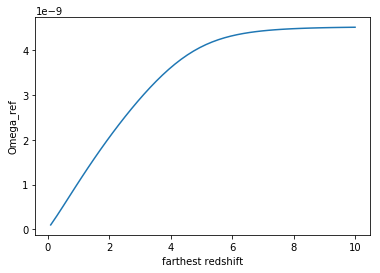

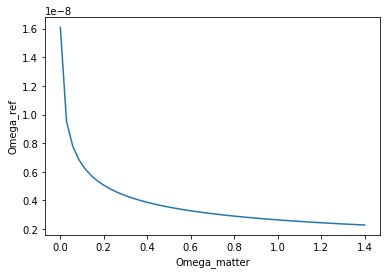

In [6]:
plt.plot(zf_array,Omega_gw_z_free)
#plt.axhline(OmegaGW_limit)
plt.xlabel('farthest redshift')
plt.ylabel('Omega_ref')
plt.show()

plt.plot(Omega_m_array,Omega_gw_Omegam_free)
#plt.axhline(OmegaGW_limit)
plt.xlabel('Omega_matter')
plt.ylabel('Omega_ref')
plt.show()

### Examining interplay between redshift evolution of rate and mass distributions
find `zp` as a function of `beta_q`, given `Omega_gw_limit` :

To do this, I need to create a grid of `zp` and `beta_q` and compute `Omega_gw` for each point on that grid. Then, I need to find the subspace where `Omega_GW < Omega_gw_limit`

The contour of `Omega_GW == Omega_gw_limit` for a given `alpha` is the function $z_{peak} (\beta_q)$ - so for a given mass distribution and redshift evolution power law params (i.e. $\alpha, \beta$), I can solve for the peak redshift of the rate evolution.

In [173]:
beta_q_array = np.linspace(-50,50)
zp_array = np.linspace(0,5)
alpha_arr = np.linspace(-5,5,20)
Omega_gw_zb = np.zeros((len(beta_q_array),len(zp_array),len(alpha_arr)))
for z in range(len(zp_array)):
    for a in range(len(alpha_arr)):
        z_params = [zp_array[z], alpha_arr[a], 7.]
        for b in range(len(beta_q_array)):
            beta_q = beta_q_array[b]
            Omega_gw_zb[b,z,a] = OmegaGW(1000,0.3,fref,massdist=plaw_selection,z_evo_params=z_params)

In [174]:
Omega_xr = xr.DataArray(Omega_gw_zb,
                        dims = ('beta_q','zp','alpha'),
                        coords = (beta_q_array,zp_array,alpha_arr),
                        name = 'Omega_GW')

In [175]:
Omega_xr.to_netcdf('OmegaGW_betaq_zp_alphaneg5to5.nc')

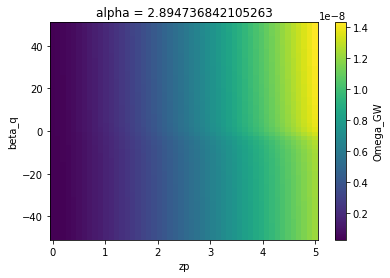

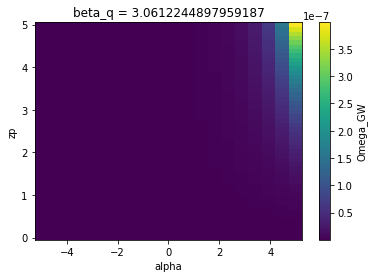

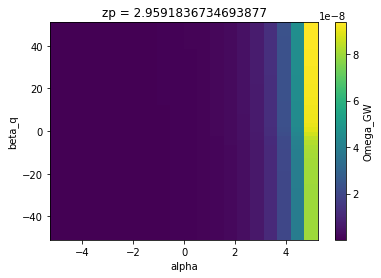

In [184]:
Omega_xr.sel({'alpha':3},method='nearest').plot()#(norm=LogNorm())#(norm=LogNorm(vmin=1e-20, vmax=1e45))
plt.show()
#cbar spans 1-10 OOM (less than 1 for all alpha in range [-5,5])

Omega_xr.sel({'beta_q':3},method='nearest').plot()#(norm=LogNorm())#(norm=LogNorm(vmin=1e-20, vmax=1e45))
plt.show()
#cbar spans 56 OOM over alpha in [-20,20] and 3 OOM over alpha in [-5,5]

Omega_xr.sel({'zp':3},method='nearest').plot()#(norm=LogNorm())#(norm=LogNorm(vmin=1e-20, vmax=1e45))
plt.show()
#cbar spans 42 OOM over alpha in [-20,20] and 2 OOM over alpha in [-5,5]

looking at the colorbars, alpha seems to have the largest effect whereas beta_q and zp dont really, since changing alpha from -20 to 20 changes Omega_gw by ~50 OOM (keeping beta_q or zp fixed), wheras keeping alpha fixed and changing zp from 0 to 5 and beta_q from -40 to 40 changes Omega_GW by a maximum of 10 OOM (although the range of the values for Omega_GW depends heavily on the chosen fixed value of alpha - for example, alpha=0 makes the range of omega gw less than 1 OOM). This might just be because of the limits ive chosen for them, but the range of zpeak is physically reasonable - the value of the itnegral shouldnt change much after z ~ O(10) - and the range on beta_q is larger than that on alpha! Therefore, I think the mass distribution (determined by beta_q) has a much smaller effect than the redshift evolution (determined by zp and alpha). I should still probably do this again with more values of alpha over a smaller range.

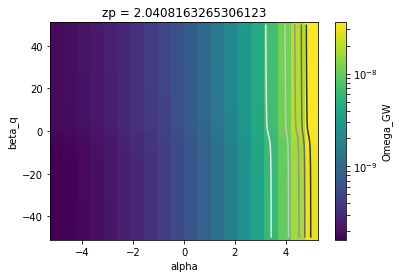

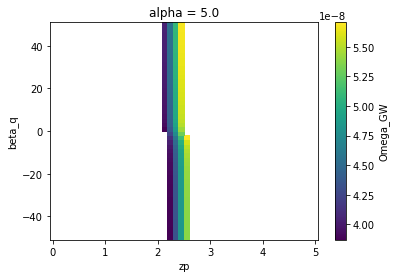

In [188]:
# plot space where omega_Gw is below the limit
Omega_xr.sel(zp=2, method='nearest').plot.imshow(norm=LogNorm())
Omega_xr.where(Omega_xr.data < OmegaGW_limit).sel(zp=2, method='nearest').plot.contour(cmap='Greys')
plt.show()

#plot values where omega_GW is at/near the limit
Omega_xr.where(np.logical_and(Omega_xr.data > OmegaGW_limit-1e-8,
                              Omega_xr.data < OmegaGW_limit+1e-8)
              ).sel(alpha=5,method='nearest').plot() #shouts and murmurs constrains alpha to be ~5 so lets use this for now
plt.show()
#again this shows a much greater ability to constrain the redshift evolution params than the pairing function param:
#contours are basically vertical, only change is for a negative or positive beta_q

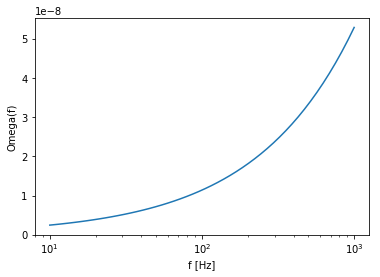

In [8]:
# redshift_evolution_parameters = [5.,2.,7.] #zpeak, alpha, beta
# f_array = np.logspace(1,3) * u.Hz
# Omega_gw_of_f = np.zeros_like(f_array / u.Hz)

# for i in range(len(f_array)):
#     f=f_array[i]
#     Omega_gw_of_f[i] = OmegaGW(10, 0.3, fref=f,massdist=plaw_selection,z_evo_params=redshift_evolution_parameters)

plt.plot(f_array,Omega_gw_of_f)
#plt.axhline(OmegaGW_limit)
plt.xlabel('f [Hz]')
plt.ylabel('Omega(f)')
plt.xscale('log')
# plt.yscale('log')
plt.show()

oh lol obviously its going to be linear on a log-log... im enforcing it to be a power law!